## Bayesian Optimization with Scikit-Optimize

This Notebook is an overview of the Convoluted Neural Network used to verify the accuracy of data for hand gestures.Admittedly barebones and can only recognise the gestures given here, its a good foundation to build upon this dataset

### Hyperparameter Tunning Procedure

To tune the hyper-parameters of our model we need to:

- define a model (a CNN in this case)
- decide which parameters to optimize
- define the objective function we want to minimize.


### NOTE

Scikit-Optimize will always **minimize** the objective function, so if we want to maximize a function, for example the roc-auc, we need to **negate** the metric. Thus, instead of maximizing the roc-auc, we minimize the -roc-auc.

In [1]:
# the necessary imports required to make this work

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Reshape

from skopt import BayesSearchCV
from skopt.space import Categorical

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from tensorflow.keras.callbacks import EarlyStopping

from skopt import gp_minimize
from skopt.utils import use_named_args
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
# load the dataset, each file represents a gesture
file_paths = [
    r'C:\Users\agust\Desktop\Gesture Data\0.csv',
    r'C:\Users\agust\Desktop\Gesture Data\1.csv',
    r'C:\Users\agust\Desktop\Gesture Data\2.csv',
    r'C:\Users\agust\Desktop\Gesture Data\3.csv'
]

dataframes = []

for file_path in file_paths:
    df = pd.read_csv(file_path, header=None)
    dataframes.append(df)

# Combine all dataframes into a single dataframe
data = pd.concat(dataframes, axis=0, ignore_index=True)

# Separate features and labels =
X = data.iloc[:, :-1]  # All columns except the last one
y = data.iloc[:, -1]   # The last column


In [3]:
# normalise, then split dataset into a train and test set

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled = X_scaled.reshape(-1, 8, 8, 1)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)



## Define the model

In [14]:
from keras.layers import Dropout

# construction of the CNN 

def build_model(n_conv_layers, n_filters, filter_size, n_dense_layers, n_dense_units, dropout_rate):
    model = Sequential()
    model.add(Input(shape=(8, 8, 1)))
    
    # Add convolutional layers
    for _ in range(n_conv_layers):
        model.add(Conv2D(n_filters, filter_size, activation='relu', padding='same'))
        model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    
    # Add dense layers
    for _ in range(n_dense_layers):
        model.add(Dense(n_dense_units, activation='relu'))
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(4, activation='softmax'))  # 4 gesture classes
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Parameters

param_space = {
    'n_conv_layers': (1, 3),
    'n_filters': (16, 64),
    'filter_size': Categorical([(2, 2)]),
    'n_dense_layers': (1, 3),
    'n_dense_units': (64, 256),
    'dropout_rate': (0.0, 0.5)
}

In [15]:
def objective(params):
    param_dict = dict(zip(param_space.keys(), params))
    model = build_model(**param_dict)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=0)
    return -np.max(history.history['val_accuracy'])  # minimize negative validation accuracy

# Perform Bayesian optimization
result = gp_minimize(objective, dimensions=list(param_space.values()), n_calls=10, random_state=42)

# Get the best parameters
best_params = dict(zip(param_space.keys(), result.x))

# Train the model with the best parameters
best_model = build_model(**best_params)
best_model.fit(X_train, y_train, epochs=20, validation_split=0.2)

Epoch 1/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7342 - loss: 0.6866 - val_accuracy: 0.9160 - val_loss: 0.2542
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9254 - loss: 0.2259 - val_accuracy: 0.9315 - val_loss: 0.1969
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9415 - loss: 0.1681 - val_accuracy: 0.9406 - val_loss: 0.1780
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9551 - loss: 0.1431 - val_accuracy: 0.9454 - val_loss: 0.1687
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9575 - loss: 0.1202 - val_accuracy: 0.9460 - val_loss: 0.1518
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9642 - loss: 0.1018 - val_accuracy: 0.9353 - val_loss: 0.1848
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9626 - loss: 0.1060 - val_accuracy: 0.9513 - val_loss: 0.1553
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9694 - loss: 0.0861 - val_accuracy: 0.

In [16]:
print("Best parameters found: ", result.x)

# Evaluate the best model
best_model = build_model(**best_params)
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f'Test accuracy of the best model: {test_accuracy}')

Best parameters found:  [1, 41, (2, 2), 1, 251, 0.11638567021515214]
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - accuracy: 0.2568 - loss: 1.4453
Test accuracy of the best model: 0.26284247636795044


## Ploting the Results

[plot_convergence](https://scikit-optimize.github.io/stable/modules/generated/skopt.plots.plot_convergence.html#skopt.plots.plot_convergence)

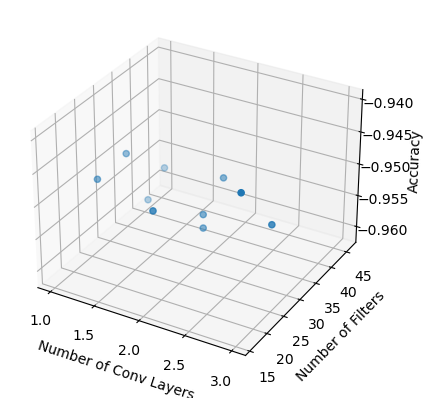

In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

results = result.func_vals
n_conv_layers = [p[0] for p in result.x_iters]
n_filters = [p[1] for p in result.x_iters]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(n_conv_layers, n_filters, results)
ax.set_xlabel('Number of Conv Layers')
ax.set_ylabel('Number of Filters')
ax.set_zlabel('Accuracy')
plt.show()